# 8. Blind Decoding Of Physical Downlink Control Channel on Plutto-SDR

The tutorial demonstrates the downlink synchronization using synchronization signal block (SSB) and PDCCH blind decoding in 5G networks.
The SSB consists of 4 elements:

- Primary Synchronization Signal (PSS)
- Secondary Synchronization Signal (SSS)
- Physical Broadacast Channel (PBCH) Payload: 432 symbols
- Demodulation Reference Signal (DMRS) for PBCH

The PDCCH consists of 2 elements:
- Define the PDCCH coreset and search space set parameters.
    - Aggregation level
    - frequency domain resources
    - duration
    - monitoring symbols with in a slot
    - search space set type
    - CCE to REG mapping
    - REG bundle size
    - Interleaver size
    - shift index 
    
- Decode the PDCCH candidates blindly based on the chosen parameters.

The tutorial performs following procedures:

- [Import Libraries](#8.-Import-Libraries)
    - [Import Python Libraries](#8.-Import-Python-and-SDR-Libraries)
    - [Import 5G Toolkit Libraries](#8.-Import-5G-Toolkit-Libraries)
- [Emulation Configurations](#8.-Emulation-Configurations)
- [Construct SSB](#8.-Generate-the-SSB-Grid-for-synchronization)
    - Generate PSS
    - Generate PSS
    - Generate PBCH
    - Generate DMRS-PBCH
    - Generate SSB
- [CORESET and Search Space Set](#8.-CORESET-and-Search-Space-Set-Parameters)
- [Display SSB and PDCCH Grid](#8.-Display-Grids)
    - [PDCCH Grid](#8.-PDCCH-Grid)
    - [SSB Grid](#8.-SSB-Grid)
    - [Transmission Grid](#8.-SSB,-PDCCH-Merged-Grid)
- [Constellation Diagram](#8.-Constellation-Diagram)
- [OFDM Modulation](#8.-OFDM-Modulation:-Tx)
    - Insert SSB to Tx Resource Grid
    - OFDM Modulation
- [SDR Configuration](#8.-SDR-Setup-Configurations)
- [Transmit using SDR RF Transmitter](#8.-Transmission:-SDR-RF-Transmitter)
- [Receive using SDR RF Receiver](#8.-Reception:-SDR-RF-Receiver)
    - [Receiver Implementation](#8.-Receiver-Implementation)
- [Time Synchronization](#8.-Time-Synchronization:-Based-on-PSS-Correlation)
- [OFDM Receiver and SSB Grid Extraction](#8.-OFDM-Demodulation-and-SSB-Extraction)
    - [Tx-Rx SSB Grid Comparison](#8.-SSB-Grid:-Transmitter-and-Receiver)
    - [Tx-Rx Spectrum Comparison](#8.-Spectrum:-Transmitted-Grid-and-Received-Grid)
- [Parameter Estimation](#8.-Parameter-Estimation-for-SSB-and-PBCH)
- [PBCH Estimates](#8.-Channel-Estimation-and-PBCH-Symbol-Equalization)
    - Channel Estimation
    - Equalization
    
- [PBCH Decoding](#8.-PBCH-Decoding-and-Constellation)
    - MIB Decoding
    - ATI Decoding
    
- [BER Computation](#8.-Performance-Verification)
- [PDCCH Estimation](#8.-Channel-Estimation-and-Equalization-of-PDCCH)
- [PDCCH Blind Decoding](#8.-Blind-Decoding-of-PDCCH-candidates)
- [COnstellation of Received PDCCH symbols](#8.-Received-Constellation)
- [Quasi-real-time-animation](#8.-Quasi-real-time-animation)


## 8. Import Libraries
### 8. Import Python and SDR Libraries

In [1]:
# %matplotlib widget

# from IPython.display import display, HTML
# display(HTML("<style>.container { width:90% !important; }</style>"))

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation

import numpy as np
import adi


### 8. Import 5G Toolkit Libraries 

In [2]:
import sys
sys.path.append(".")

from toolkit5G.SequenceGeneration import PSS, SSS, DMRS
from toolkit5G.PhysicalChannels   import PBCH, PBCHDecoder, PDCCH, PDCCHDecoder, PDCCHCandidateBlindDecoding
from toolkit5G.ResourceMapping    import SSB_Grid, ResourceMapperSSB, ResourceMappingPDCCH, CORESET, SearchSpaceSet
from toolkit5G.OFDM               import OFDMModulator, OFDMDemodulator
from toolkit5G.MIMOProcessing     import AnalogBeamforming, ReceiveCombining
from toolkit5G.ReceiverAlgorithms import PSSDetection, SSSDetection, ChannelEstimationAndEqualization, DMRSParameterDetection
from toolkit5G.ReceiverAlgorithms import ChannelEstimationAndEqualizationPBCH, ChannelEstimationAndEqualizationPDCCH
from toolkit5G.Configurations     import TimeFrequency5GParameters, GenerateValidSSBParameters


## 8. Emulation Configurations

In [3]:
###################
# System Parameters
###################

center_frequency    = 2*1e9  # center or carrier frequency in Hz
numerology          = 0   
slotNumber          = 0

# OFDM Parameters
Bandwidth           = 30*10**6
fftSize             = 2048
subcarrier_spacing  = 15000
numOFDMSymbols      = 14
sample_rate         = fftSize*subcarrier_spacing

# Pulse Shaping
numSamplesPerSymbol = 1


# number of samples returned per call to rx()
buffer_size         = int(fftSize*1.2*numSamplesPerSymbol*numOFDMSymbols) 

## 8. Transmitter Implementation
## 8. Generate the SSB Grid for synchronization


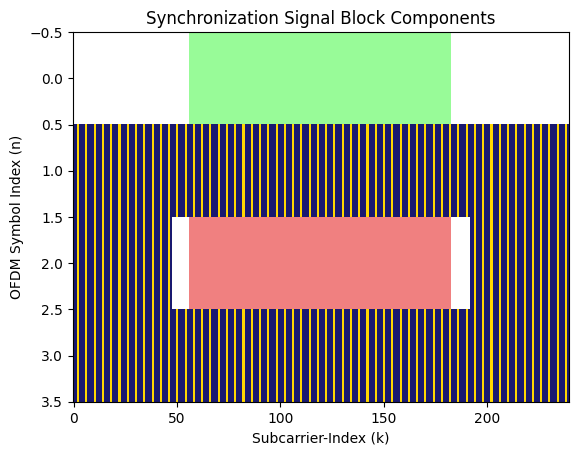

In [4]:
## This class fetches valid set of 5G parameters for the system configurations
nSymbolFrame= int(140*subcarrier_spacing/15000)
## This class fetches valid set of 5G parameters for the system configurations 
tfParams    = TimeFrequency5GParameters(Bandwidth, subcarrier_spacing)
tfParams(nSymbolFrame, typeCP = "normal")
nRB         = tfParams.numRBs      # SSB Grid size (Number of RBs considered for SSB transition)
Neff        = tfParams.Neff        # Number of resource blocks for Resource Grid ( exclude gaurd band | offsets : BWP)
Nfft        = 512                  # FFT-size for OFDM
lengthCP    = tfParams.lengthCP    # CP length
#___________________________________________________________________

#### Generate MIB Information
lamda                           = 3e8/center_frequency;
nSCSOffset                      = 1
ssbParameters                   = GenerateValidSSBParameters(center_frequency, nSCSOffset, "caseA")

systemFrameNumber               = ssbParameters.systemFrameNumber
subCarrierSpacingCommon         = subcarrier_spacing
ssbSubCarrierOffset             = ssbParameters.ssbSubCarrierOffset
DMRSTypeAPosition               = ssbParameters.DMRSTypeAPosition
controlResourceSet0             = ssbParameters.controlResourceSet0
searchSpace0                    = ssbParameters.searchSpace0

isPairedBand                    = ssbParameters.isPairedBand
nSCSOffset                      = ssbParameters.nSCSOffset
choiceBit                       = ssbParameters.choiceBit
ssbType                         = ssbParameters.ssbType
nssbCandidatesInHrf             = ssbParameters.nssbCandidatesInHrf
ssbIndex                        = ssbParameters.ssbIndex
hrfBit                          = ssbParameters.hrfBit
cellBarred                      = ssbParameters.cellBarred
intraFrequencyReselection       = ssbParameters.intraFrequencyReselection
withSharedSpectrumChannelAccess = ssbParameters.withSharedSpectrumChannelAccess

Nsc_ssb                         = 240
Nsymb_ssb                       = 4
#_______________________________________


N_ID2        = np.random.randint(3)

# Generate PSS sequence
pssObject    = PSS(N_ID2);
pssSequence  = pssObject()

N_ID1        = np.random.randint(336)
N_ID         = 3*N_ID1 + N_ID2

# Generate SSS sequence
sssObject    = SSS(N_ID1, N_ID2);
sssSequence  = sssObject()

# Generate DMRS sequence
dmrsLen      = 144;
dmrsObject   = DMRS("PBCH", N_ID, ssbIndex, nssbCandidatesInHrf, hrfBit)
# dmrsSeq = dmrs.getSequence("tensorflow")
dmrsSequence = dmrsObject(dmrsLen)


# Generate PBCH symbols
pbchObject   = PBCH(center_frequency, choiceBit, subCarrierSpacingCommon, DMRSTypeAPosition,
                   controlResourceSet0, searchSpace0, cellBarred, intraFrequencyReselection,
                   systemFrameNumber, ssbSubCarrierOffset, hrfBit, ssbIndex, N_ID,
                   nssbCandidatesInHrf)

pbchSymbols  = pbchObject()

## Generate SSB Object
ssbObject    = SSB_Grid(N_ID, True)
ssb          = ssbObject(pssSequence, sssSequence, dmrsSequence, pbchSymbols)

## Loading SSB to Resource Grid
#####################################
# ssbPositionInBurst = np.ones(nssbCandidatesInHrf, dtype=int)
ssbPositionInBurst    = np.zeros(nssbCandidatesInHrf, dtype=int)
ssbPositionInBurst[0] = 1

ssbRGobject    = ResourceMapperSSB(ssbType=ssbType, carrierFrequency = center_frequency, 
                                   isPairedBand = isPairedBand, 
                                   withSharedSpectrumChannelAccess = withSharedSpectrumChannelAccess)

ssbGrid = ssbRGobject(ssb[0], ssbPositionInBurst, offsetInSubcarriers = ssbSubCarrierOffset[0],
                      offsetInRBs = 0, numRBs = nRB)[0:14]
fig, ax = ssbObject.displayGrid(option=1)


In [5]:
ssbGrid.shape

(14, 1920)

## 8. CORESET and Search Space Set Parameters

In [6]:
AggLevel = 2

monitoringSymbolsWithinSlot = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype = int)
startSymIndex               = np.nonzero(monitoringSymbolsWithinSlot)[0][0]

coresetID       = 1
cce_reg_Mapping = "interleaved" # CCE to REG mapping type
L               = 6             # REG-bundle size 
R               = 2             # Interleaver size 
nshift          = 0             # cyclic-shift index after interleaving

duration        = 1             # duration of CORESET 
frequencyDomainResources = np.array([1,1,1,1,1,1,1,1,0,
                                     0,0,0,0,0,0,0,0,0,
                                     0,0,0,0,0,0,0,0,0,
                                     0,0,0,0,0,0,0,0,0,
                                     0,0,0,0,0,0,0,0,0], dtype = int) 

RNTI         = int(1 + np.random.randint(65518, dtype = int)) # radio network temporary indentifier

coresetObj = CORESET(duration,frequencyDomainResources)
coresetPRBIndices = coresetObj(cce_REG_MappingType = cce_reg_Mapping, 
                               reg_BundleSize=L, interleaverSize = R, shiftIndex = nshift)
ssType                   = "USS"
AggLevel                 = 2                                 # Aggregation level
coresetSize              = coresetObj.numCCESInCoreset       # CORESET size in number of CCEs
numCandidatesPerAL       = np.array([2,4,0,0,0], dtype=int)  # number of pdcch candidates per Aggregation Level.
ssObj = SearchSpaceSet(numerology = numerology, searchSpaceType = ssType, 
                       numCandidates = numCandidatesPerAL, coresetDuration = duration)

##############
# CCE indices
##############

M      = numCandidatesPerAL[int(np.log2(AggLevel))]    
ueCand = ssObj(AggLevel,RNTI,coresetSize,slotNumber,coresetID)
ueCCEs = ueCand[np.random.randint(M)]

        
        
print("#####################################################################")        
print("Duration of CORESET:", duration)
print()
print("Frequency Domain Resources:", frequencyDomainResources)
print()
print("CORESET size in CCEs:", coresetObj.numCCESInCoreset)
print()
print("Monitoring Symbols With in a Slot:", monitoringSymbolsWithinSlot)
print()
print("CORESET Start symbol index:", startSymIndex)
print()
print("#####################################################################")
print("Candidates Corresponding to UE with a chosen Aggregation Level of " + str(AggLevel) + ":\n", ueCand)
print()
print("CCEs chosen for UE:\n", ueCCEs)

#####################################################################
Duration of CORESET: 1

Frequency Domain Resources: [1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0]

CORESET size in CCEs: 8

Monitoring Symbols With in a Slot: [1 0 0 0 0 0 0 0 0 0 0 0 0 0]

CORESET Start symbol index: 0

#####################################################################
Candidates Corresponding to UE with a chosen Aggregation Level of 2:
 [[0 1]
 [2 3]
 [4 5]
 [6 7]]

CCEs chosen for UE:
 [0 1]


C:\Users\asnat\Downloads\May4\May4\toolkit5G\ResourceMapping\searchspaceset.py:506: RuntimeWarning: overflow encountered in long_scalars
  Y[p][nsf_mu] = (A[p]*Y[p][nsf_mu - 1])%D


In [7]:
nBatches     = 1                   # number of batches 
numPDCCHSym  = int(54*AggLevel)    # number of REs occupied by PDCCH data (QPSK symbols)
numPDCCHdmrs = int(18*AggLevel)    # number of REs occupied by PDCCH DMRS symbols
E            = numPDCCHSym*2       # number of target Bits
K            = 20                  # payload size in bits
dciBits      = np.random.randint(0, 2, [nBatches, K]) 

##############################################
# PDCCH chain and generation of  QPSK symbols
##############################################
pdcchObj = PDCCH(K, E, RNTI, N_ID)
symb     = pdcchObj(dciBits) 

###################
# Resource Mappping
###################
rmPDCCH      = ResourceMappingPDCCH(numerology, frequencyDomainResources, duration, monitoringSymbolsWithinSlot)
pdcchGrid    = rmPDCCH(symb, cce_reg_Mapping, L, R, nshift, slotNumber, N_ID, ueCCEs)


In [8]:
pdcchGrid.shape

(1, 14, 3240)

## 8. Display Grids

### 8. PDCCH Grid

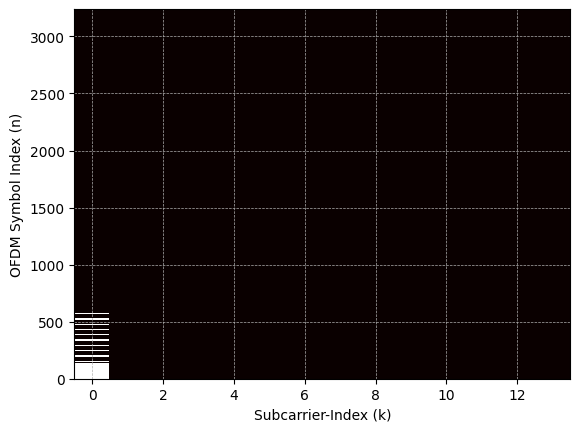

In [9]:
fig, ax = plt.subplots()
colors  = ['palegreen', 'white', 'lightcoral', 'gold', 'midnightblue', 'purple']



# Grid  = pdcchGrid[0][...,0:ssbGrid.shape[-1]]
Grid  = pdcchGrid[0]
plt.imshow(np.abs(Grid).T, interpolation='none', aspect = "auto", cmap="hot", origin='lower')


ax.tick_params(axis='both',which='minor', grid_linewidth=  2, width=0)
ax.tick_params(axis='both',which='major', grid_linewidth=0.5, grid_linestyle = '--')
ax.grid(which='both')
ax.set_xlabel("Subcarrier-Index (k)")
ax.set_ylabel("OFDM Symbol Index (n)")

plt.show()

### 8. SSB Grid

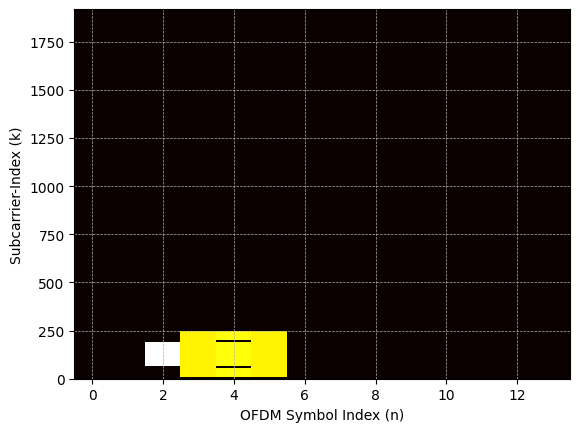

In [10]:
fig, ax = plt.subplots()
colors  = ['palegreen', 'white', 'lightcoral', 'gold', 'midnightblue', 'purple']
bounds  = [0,1,2,3,4,5,6]

plt.imshow(np.abs(ssbGrid.T), interpolation='none', aspect = "auto", cmap="hot", origin='lower')


ax.tick_params(axis='both',which='minor', grid_linewidth=  2, width=0)
ax.tick_params(axis='both',which='major', grid_linewidth=0.5, grid_linestyle = '--')
ax.grid(which='both')
ax.set_ylabel("Subcarrier-Index (k)")
ax.set_xlabel("OFDM Symbol Index (n)")

plt.show()

### 8. SSB, PDCCH Merged Grid

In [11]:
resourceGrid = ssbGrid
resourceGrid = resourceGrid + np.sqrt(1/127)*pdcchGrid[0,:,0:Neff]  # make sure that the merged grids of SSB and PDCCH do not overlap.


In [12]:
resourceGrid.shape

(14, 1920)

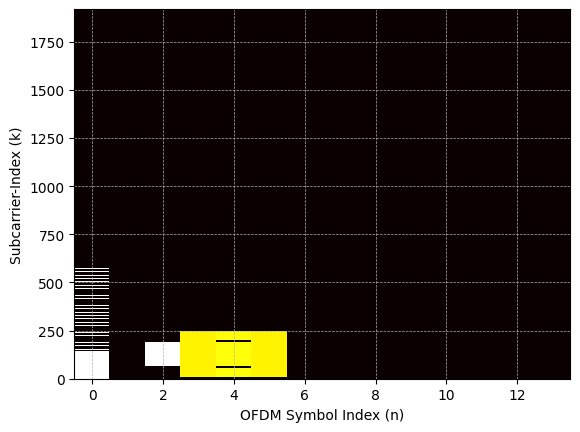

In [13]:
fig, ax = plt.subplots()
colors  = ['white', 'palegreen', 'lightcoral', 'gold', 'midnightblue', 'purple']
bounds  = [0,1,2,3,4,5,6]

plt.imshow(np.abs(resourceGrid.T), interpolation='none', aspect = "auto", cmap="hot", origin='lower')


ax.tick_params(axis='both',which='minor', grid_linewidth=  2, width=0)
ax.tick_params(axis='both',which='major', grid_linewidth=0.5, grid_linestyle = '--')
ax.grid(which='both')
ax.set_ylabel("Subcarrier-Index (k)")
ax.set_xlabel("OFDM Symbol Index (n)")

plt.show()

## 8. Constellation Diagram

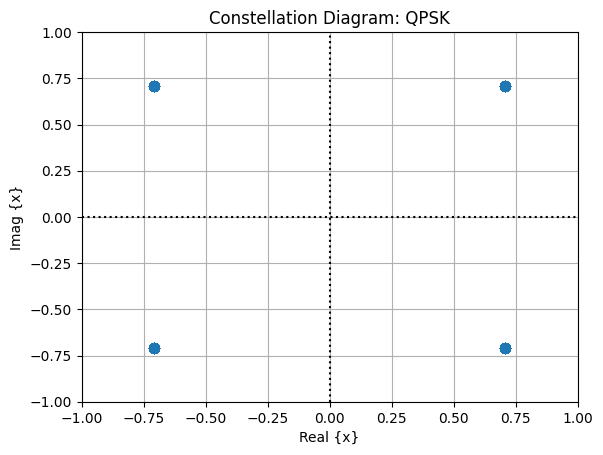

In [14]:
fig, ax = plt.subplots()
ax.scatter(np.real(pbchSymbols),  np.imag(pbchSymbols), s=48)
ax.axhline(y=0, ls=":", c="k")
ax.axvline(x=0, ls=":", c="k")
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_xlabel("Real {x}")
ax.set_ylabel("Imag {x}")
ax.set_title("Constellation Diagram: QPSK")
ax.grid()
plt.show()

## 8. OFDM Modulation: Tx

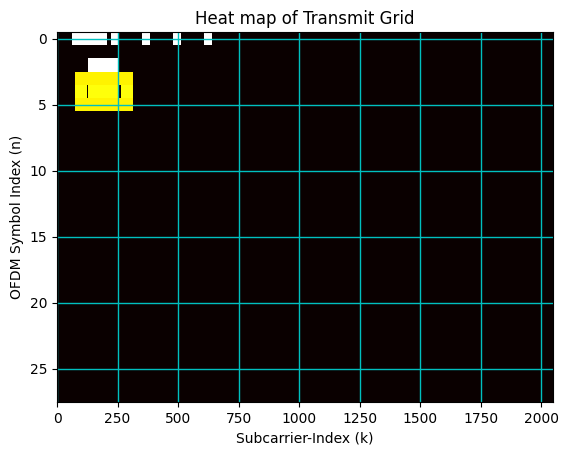

In [15]:
## Loading SSB to Resource Grid
numofGuardCarriers = (int((fftSize - Neff)/2), int((fftSize - Neff)/2))
offsetToPointA     = 0
firstSCIndex       = int(numofGuardCarriers[0] + offsetToPointA)
numOFDMSymbols     = ssbGrid.shape[0]

X = np.zeros((numOFDMSymbols, fftSize), dtype= np.complex64)
X2 = np.zeros((numOFDMSymbols, fftSize), dtype= np.complex64)
X[:, firstSCIndex:firstSCIndex+ssbGrid.shape[-1]] = resourceGrid
X = np.concatenate([X, X2], axis = 0)

#__________________________________________________

## OFDM Modulation at Transmitter
#####################################
modulator = OFDMModulator(lengthCP[1])
x_time    = modulator(X).flatten()
#______________________________________________________

# Plot Resource Grid
#################################################################
fig, ax = plt.subplots()
plt.imshow(np.abs(X), cmap = 'hot', interpolation='nearest', aspect = "auto")
ax = plt.gca();
ax.grid(color='c', linestyle='-', linewidth=1)
ax.set_xlabel("Subcarrier-Index (k)")
ax.set_ylabel("OFDM Symbol Index (n)")
ax.set_title("Heat map of Transmit Grid")
# Gridlines based on minor ticks
plt.show()

## 8. SDR-Setup Configurations

In [16]:
# Basic SDR Setup
sdr = adi.Pluto("ip:192.168.3.1")
sdr.sample_rate = int(sample_rate)

# Config Tx
sdr.tx_rf_bandwidth = int(sample_rate) # filter cutoff, just set it to the same as sample rate
sdr.tx_lo           = int(center_frequency)
sdr.tx_hardwaregain_chan0 = -30 # Increase to increase tx power, valid range is -90 to 0 dB

# Config Rx
sdr.gain_control_mode_chan0 = 'slow_attack'
# sdr.rx_hardwaregain_chan0   = 40.0      # dB
# The receive gain on the Pluto has a range from 0 to 74.5 dB.

# sdr.gain_control_mode_chan0 = 'slow_attack'
# # AGC modes: 
#     # 1. "manual"
#     # 2. "slow_attack"
#     # 3. "fast_attack"

sdr.rx_lo           = int(center_frequency)
sdr.rx_rf_bandwidth = int(60*10**6) # filter width, just set it to the same as sample rate for now
sdr.rx_buffer_size  = int(4*buffer_size)

## 8. Transmission: SDR RF Transmitter

In [17]:
sdr.tx_destroy_buffer()
# Start the transmitter
sdr.tx_cyclic_buffer = True # Enable cyclic buffers
# sdr.tx_cyclic_buffer = False # Enable cyclic buffers
sdr.tx(1.3*2**17*(x_time.repeat(1))) # start transmitting


## 8. Receiver Implementation

## 8. Reception: SDR RF Receiver

In [18]:

# Clear buffer just to be safe
for i in range (0, 10):
    raw_data = sdr.rx()

# Receive samples
rx_samples = sdr.rx()

# # Stop transmitting
# sdr.tx_destroy_buffer()


## 8. Time Synchronization: Based on PSS Correlation

**(rasterOffset, PSS-ID) (74, 0)
**(rasterOffset, PSS-ID) (74, 1)
**(rasterOffset, PSS-ID) (74, 2)


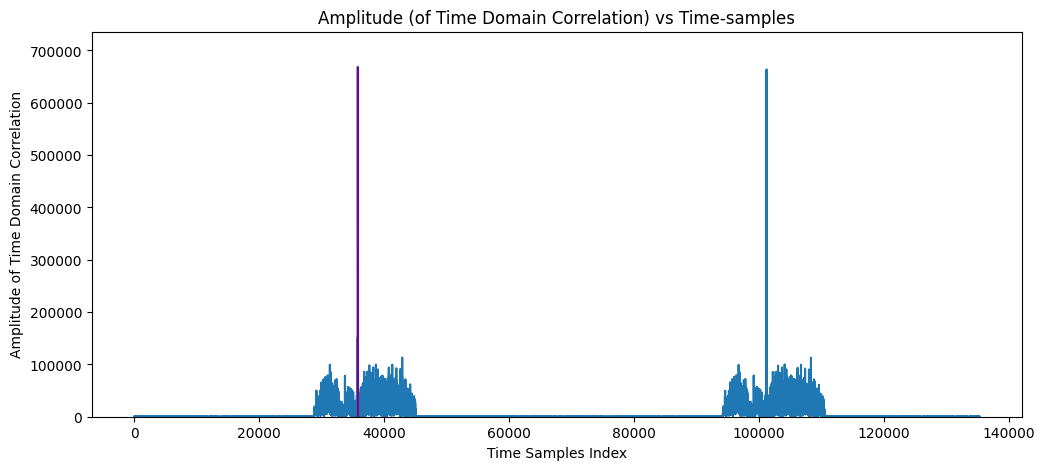

In [19]:
## PSS Detection: Based on time domain PSS Correlation
# pssPeakIndices, pssCorrelation, rN_ID2 = pssDetection(r, Nfft, lengthCP = lengthCP[1],
#                                                       N_ID2 = None, freqOffset = ssboffset,
#                                                       height = 0.75, prominence = 0.65, width=10)
## PSS Detection: Based on time domain PSS Correlation
# pssDetection   = PSSDetection("correlation", "threshold")

pssDetection   = PSSDetection("largestPeak")
ssboffset      = int((fftSize-Neff)/2+ssbRGobject.startingSubcarrierIndices)
pssPeakIndices, pssCorrelation, rN_ID2, freqOffset = pssDetection(rx_samples, fftSize, lengthCP = lengthCP[1], 
                                                                  nID2=None, freqOffset = ssboffset)

if(pssPeakIndices > rx_samples.size - 28*(fftSize + lengthCP[1])):
    pssPeakIndices = pssPeakIndices - 28*(fftSize + lengthCP[1])
    
## PSS Detection Plot
#################################################################
fig, ax  = plt.subplots(figsize=(12, 5))

# single line
ax.plot(pssCorrelation)
ax.vlines(x = pssPeakIndices, ymin = 0*pssCorrelation[pssPeakIndices],
           ymax = pssCorrelation[pssPeakIndices], colors = 'purple')
ax.set_ylim([0,np.max(pssCorrelation)*1.1])
ax.set_xlabel("Time Samples Index")
ax.set_ylabel("Amplitude of Time Domain Correlation")
ax.set_title("Amplitude (of Time Domain Correlation) vs Time-samples")
plt.show()
#________________________________________________________________

## 8. OFDM Demodulation and SSB Extraction

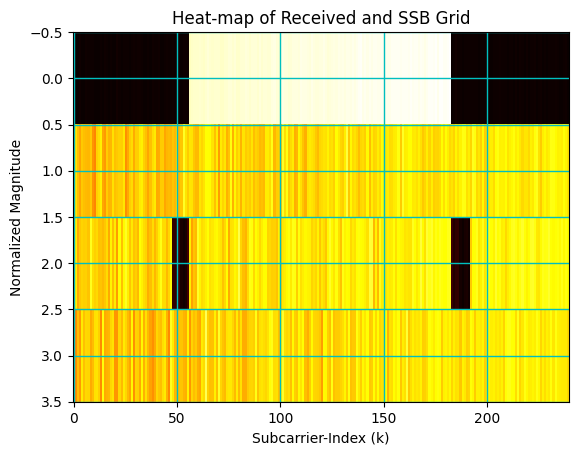

In [20]:
## OFDM Demodulator Object
ofdmDemodulator = OFDMDemodulator(fftSize, lengthCP[1])
pssStartIndex   = pssPeakIndices
# pssStartIndex   = pssPeakIndices[0][0]
rxGrid          = ofdmDemodulator((rx_samples.reshape(1,-1))[...,pssStartIndex:(pssStartIndex+4*(fftSize+lengthCP[1]))])

ssbSCSoffset   = int((fftSize-Neff)/2+ssbRGobject.startingSubcarrierIndices)
ssbEstimate    = rxGrid[:,:,ssbSCSoffset:(ssbSCSoffset+240)]

# Plot SSB
fig, ax = plt.subplots()
plt.imshow(np.abs(ssbEstimate[0]), cmap = 'hot', interpolation='nearest', aspect = "auto")
ax = plt.gca();
ax.grid(color='c', linestyle='-', linewidth=1)
ax.set_xlabel("Subcarrier-Index (k)")
ax.set_ylabel("Normalized Magnitude")
ax.set_title("Heat-map of Received and SSB Grid")
plt.show()


## 8. SSB Grid: Transmitter and Receiver

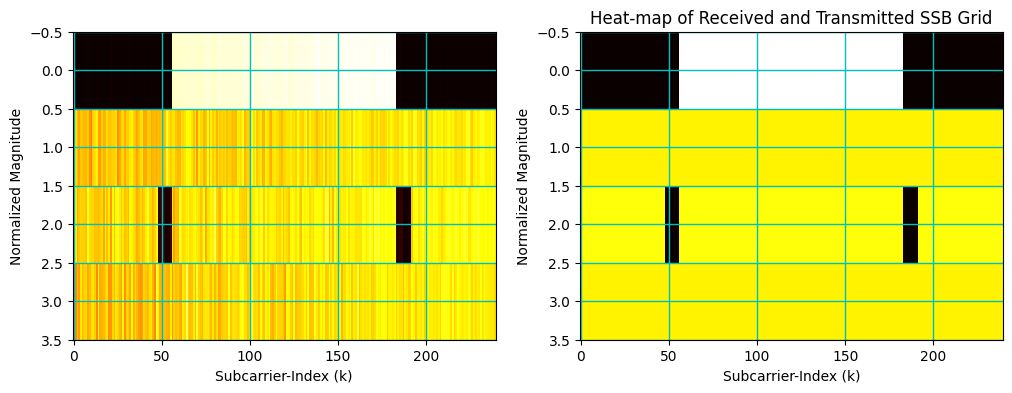

In [21]:
# Plot SSB
fig, ax = plt.subplots(1,2, figsize=(12, 4))
ax[0].imshow(np.abs(ssbEstimate[0]), cmap = 'hot', interpolation='nearest', aspect = "auto")
ax[0].grid(color='c', linestyle='-', linewidth=1)
ax[0].set_xlabel("Subcarrier-Index (k)")
ax[0].set_ylabel("Normalized Magnitude")

ax[1].imshow(np.abs(ssb[0]), cmap = 'hot', interpolation='nearest', aspect = "auto")
ax[1].grid(color='c', linestyle='-', linewidth=1)
ax[1].set_xlabel("Subcarrier-Index (k)")
ax[1].set_ylabel("Normalized Magnitude")
plt.title("Heat-map of Received and Transmitted SSB Grid")

plt.show()

## 8. Spectrum: Transmitted Grid and Received Grid

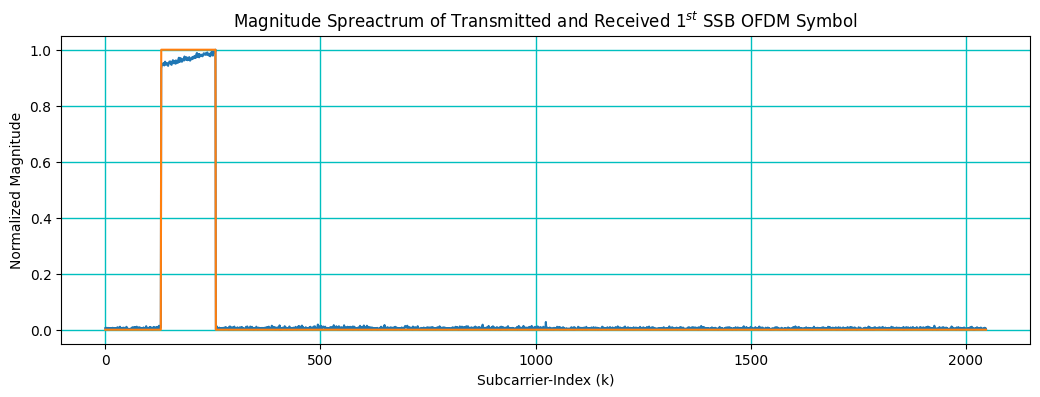

In [22]:
# Plot SSB
fig, ax = plt.subplots(figsize=(12.5, 4))
ax.plot(np.abs(rxGrid[0][0])/np.abs(rxGrid[0][0]).max())
ax.plot(np.abs(X[2])/np.abs(X[2]).max())
ax.grid(color='c', linestyle='-', linewidth=1)
ax.set_xlabel("Subcarrier-Index (k)")
ax.set_ylabel("Normalized Magnitude")
ax.set_title("Magnitude Spreactrum of Transmitted and Received $1^{st}$ SSB OFDM Symbol")
plt.show()

## 8. Parameter Estimation for SSB and PBCH

In [23]:
## N_ID_1 Estimation: SSS based
sssDetection   = SSSDetection(method="channelAssisted", nID2=rN_ID2)
rN_ID1         = sssDetection(ssbEstimate[0])
rN_ID          = 3*rN_ID1 + rN_ID2

## Generate SSB object to get DMRS and PBCH Indices
rxSSBobject    = SSB_Grid(rN_ID)
rxDMRSIndices  = rxSSBobject.dmrsIndices

## Generate DMRS sequence
dmrsDetection  = DMRSParameterDetection(int(rN_ID), nssbCandidatesInHrf)
rssbIndex, rHrfBit = dmrsDetection(ssbEstimate[0])
rxDMRSobject   = DMRS("PBCH", int(rN_ID), int(rssbIndex), nssbCandidatesInHrf, rHrfBit)
rxDMRSseq      = rxDMRSobject(dmrsLen)

## 8. Channel Estimation and PBCH Symbol Equalization

In [24]:
# ## Estimating the channel at DMRS (t-f) location, interpolting for data (t-f) location and equalizing the symbols
# ## Object for Channel Estimation
# chanEst        = ChannelEstimationAndEqualization(estimatorType = "ZF", interpolatorType = "NN")
# rxPBCHIndices  = rxSSBobject.pbchIndices
# pbchEstimate   = chanEst(ssbEstimate, rxDMRSseq, rxDMRSIndices, rxPBCHIndices, 10)

chanEst        = ChannelEstimationAndEqualizationPBCH(estimatorType = "ZF", interpolatorType = "Linear", isUEmobile=True)
pbchEstimate   = chanEst(ssbEstimate, rxDMRSseq, rN_ID)

## 8. PBCH Decoding and Constellation

C:\Users\asnat\Downloads\May4\May4\toolkit5G\ChannelCoder\PolarCoder\polarDecoder.py:494: UserWarning: Required ressource allocation is large for the selected blocklength. Consider option `cpu_only=True`.
  warnings.warn("Required ressource allocation is large " \


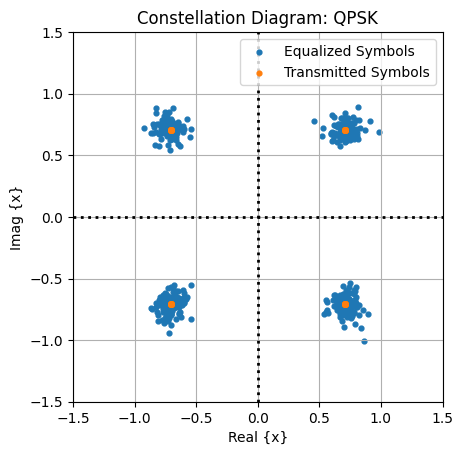

In [25]:
## PBCH Chain for Decoding information
polarDecoder   = "SCL"
symbolDemapper = "maxlog"
# extractMIBinfo = False
extractMIBinfo = True
# carrierFreq, cellID, nssbCandidatesInHrf, ssbIndex, polarDecType, symbolDemapperType
pbchDecoder    = PBCHDecoder(center_frequency, int(rN_ID), nssbCandidatesInHrf, rssbIndex, polarDecoder, symbolDemapper)
rxMIB, check   = pbchDecoder(pbchEstimate, 10, extractMIBinfo)


fig, ax = plt.subplots()
ax.set_aspect(True)
ax.scatter(np.real(pbchEstimate), np.imag(pbchEstimate), s = 12, label = "Equalized Symbols")
ax.scatter(np.real(pbchSymbols), np.imag(pbchSymbols), s = 12, label = "Transmitted Symbols")
ax.grid()
ax.axhline(y=0, ls=":", c="k", lw = 2)
ax.axvline(x=0, ls=":", c="k", lw = 2)
ax.set_xlim([-1.5,1.5])
ax.set_ylim([-1.5,1.5])
ax.set_xlabel("Real {x}")
ax.set_ylabel("Imag {x}")
ax.set_title("Constellation Diagram: QPSK")
ax.legend(loc = "best")
plt.show()

In [26]:
check

array([[ True]])

In [27]:
pbchDecoder.mibRx.displayParameters(0)

Carrier Frequency:	2000000000.0
ChoiceBit:  		1
nSsbCandidatesInHrf: 	4
subCarrierSpacingCommon:15000
DMRSTypeAPosition: 	typeA
controlResourceSet0:	10
searchSpace0: 		7
cellBarred: 		barred
intraFreqReselection: 	allowed
systemFrameNumber: 	528
ssbSubCarrierOffset: 	10
HRFBit: 		0
iSSBindex: 		0


In [28]:
pbchObject.mib.displayParameters(0)

Carrier Frequency:	2000000000.0
ChoiceBit:  		1
nSsbCandidatesInHrf: 	4
subCarrierSpacingCommon:15000
DMRSTypeAPosition: 	typeA
controlResourceSet0:	10
searchSpace0: 		7
cellBarred: 		barred
intraFreqReselection: 	allowed
systemFrameNumber: 	528
ssbSubCarrierOffset: 	10
HRFBit: 		0
iSSBindex: 		0


## 8. Performance Verification

In [29]:
if (rN_ID == N_ID):
    print("[Success]: Cell-IDs correctly detected!")
else:
    if (rN_ID1 != N_ID1 and rN_ID2 != N_ID2):
        print("[Failed]: Receiver couldn't detect the Cell-ID1 and cell-ID2 correctly!")
    elif(rN_ID1 != N_ID1):
        print("[Failed]: Receiver couldn't detect the Cell-ID1 correctly!")
    else:
        print("[Failed]: Receiver couldn't detect the cell-ID2 correctly!")
        
if (rssbIndex == ssbIndex[0]):
    print("[Success]: DMRS parameters correctly detected!")
else:
    print("[Failed]: Receiver couldn't detect the ssbIndex correctly!")
    
## Computing BER: Coded and Uncoded
numUEs = 1
nBatch = 1
uncodedBER     = np.zeros((numUEs, nBatch))
codedBER       = np.zeros((numUEs, nBatch))

bitEst         = pbchDecoder.llr.copy()
bitEst[pbchDecoder.llr  > 0]   = 1
bitEst[pbchDecoder.llr  < 0]   = 0
uncodedBER = np.mean(np.abs(bitEst - pbchObject.scr2bits[0]))
codedBER   = np.mean(np.abs(pbchDecoder.pbchDeInterleavedBits - pbchObject.mibSequence[0]))

print(" (uncoded-BER, codedBER): "+str((uncodedBER, codedBER)))

[Success]: Cell-IDs correctly detected!
[Success]: DMRS parameters correctly detected!
 (uncoded-BER, codedBER): (0.0, 0.0)


In [30]:

ofdmDemodulator  = OFDMDemodulator(fftSize, lengthCP[1])
startSampleIndex = pssPeakIndices - 2*(fftSize + lengthCP[1])
# pssStartIndex   = pssPeakIndices[0][0]
rxResGrid        = ofdmDemodulator((rx_samples.reshape(1,-1))[...,startSampleIndex:(startSampleIndex+14*(fftSize+lengthCP[1]))])

rxGrid           = rxResGrid[0,:,firstSCIndex:firstSCIndex+Neff]

In [31]:
rxResGrid.shape

(1, 14, 2048)

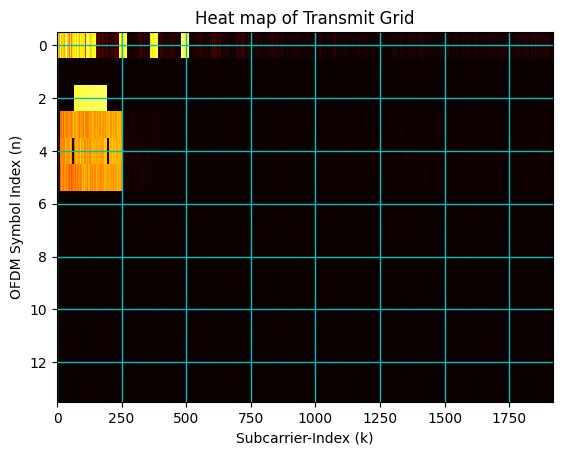

In [32]:
# Plot Resource Grid
#################################################################
fig, ax = plt.subplots()
plt.imshow(np.abs(rxGrid), cmap = 'hot', interpolation='nearest', aspect = "auto")
ax = plt.gca();
ax.grid(color='c', linestyle='-', linewidth=1)
ax.set_xlabel("Subcarrier-Index (k)")
ax.set_ylabel("OFDM Symbol Index (n)")
ax.set_title("Heat map of Transmit Grid")
# Gridlines based on minor ticks
plt.show()

## 8. Channel Estimation and Equalization of PDCCH

In [33]:
rxPDCCHGrid = np.zeros((14,270*12), dtype = np.complex64)
rxPDCCHGrid[:,0:Neff] = rxGrid

In [34]:
##### Channel Estimation and Equalization #####
snr           = 10
channelEst    = ChannelEstimationAndEqualizationPDCCH(duration, frequencyDomainResources, monitoringSymbolsWithinSlot)
equalized_Sym = channelEst(rxPDCCHGrid[np.newaxis], cce_reg_Mapping, L, R, nshift,slotNumber, N_ID)
equalizedGrid = rxPDCCHGrid[np.newaxis]/channelEst.Hest


## 8. Blind Decoding of PDCCH candidates

In [35]:
#########################
# Intiate Blind Decoding 
#########################
bdObj  = PDCCHCandidateBlindDecoding(coresetPRBIndices, duration, startSymIndex, ssType, AggLevel ,ueCand)
bdObj(equalizedGrid, K, E, snr, RNTI,N_ID, decoderType="SC", demappingMethod="app")
print("##########################################################################")
print()

------------------------------------------------------------------------------------------
Checking the CRC:
 [[ True]]
Blind Decoding Successful for the CCE Indices [0 1]..!
##########################################################################



### 8. Received Constellation

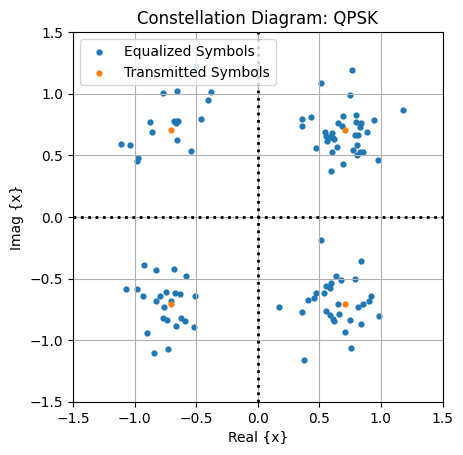

In [36]:
pdcchSymbols    = np.array([1+1j,1-1j,-1-1j,-1+1j])/np.sqrt(2)
## PBCH Chain for Decoding information

fig, ax = plt.subplots()
ax.set_aspect(True)
ax.scatter(np.real(bdObj.equalizedDataSym), np.imag(bdObj.equalizedDataSym), s = 12, label = "Equalized Symbols")
ax.scatter(np.real(pdcchSymbols), np.imag(pdcchSymbols), s = 12, label = "Transmitted Symbols")
ax.grid()
ax.axhline(y=0, ls=":", c="k", lw = 2)
ax.axvline(x=0, ls=":", c="k", lw = 2)
ax.set_xlim([-1.5,1.5])
ax.set_ylim([-1.5,1.5])
ax.set_xlabel("Real {x}")
ax.set_ylabel("Imag {x}")
ax.set_title("Constellation Diagram: QPSK")
ax.legend(loc = "best")
plt.show()
 

## 8. Quasi real time animation

In [37]:
# function that draws each frame of the animation
qpskSymbols    = np.array([1+1j,1-1j,-1-1j,-1+1j])/np.sqrt(2)

def animate(i):
    # Receive samples
    rx_samples = sdr.rx()

    pssPeakIndices, pssCorrelation, rN_ID2, freqOffset = pssDetection(rx_samples, fftSize, lengthCP = lengthCP[1],
                                                                  nID2=None, freqOffset = ssboffset)

    if(pssPeakIndices < 3*(fftSize + lengthCP[1])):
        pssPeakIndices = pssPeakIndices + 14*(fftSize + lengthCP[1])
    elif(pssPeakIndices > rx_samples.size - 13*(fftSize + lengthCP[1])):
        pssPeakIndices = pssPeakIndices - 14*(fftSize + lengthCP[1])

    # # CFO estimation
    # obj    = CarrierFrequencyOffsetEstimation(fftSize,lengthCP[1])
    # cfoEst = obj(rx_samples[pssPeakIndices: pssPeakIndices + numSamples],numCFOIteration = 2)  # Computed CFO

    ## OFDM Demodulator Object
    ofdmDemodulator  = OFDMDemodulator(fftSize, lengthCP[1])
    startSampleIndex = pssPeakIndices - 2*(fftSize + lengthCP[1])
    # pssStartIndex   = pssPeakIndices[0][0]
    rxResGrid        = ofdmDemodulator((rx_samples.reshape(1,-1))[...,startSampleIndex:(startSampleIndex+14*(fftSize+lengthCP[1]))])
    rxGrid           = rxResGrid[0,:,firstSCIndex:firstSCIndex+Neff]
    
    rxPDCCHGrid = np.zeros((14,270*12), dtype = np.complex64)
    rxPDCCHGrid[:,0:Neff] = rxGrid
    
    ##### Channel Estimation and Equalization #####
    snr           = 10
    channelEst    = ChannelEstimationAndEqualizationPDCCH(duration, frequencyDomainResources, monitoringSymbolsWithinSlot)
    equalized_Sym = channelEst(rxPDCCHGrid[np.newaxis], cce_reg_Mapping, L, R, nshift,slotNumber, N_ID)
    equalizedGrid = rxPDCCHGrid[np.newaxis]/channelEst.Hest
    
    
    ## Blind Decoding
    bdObj  = PDCCHCandidateBlindDecoding(coresetPRBIndices, duration, startSymIndex, 
                                          ssType, AggLevel ,ueCand, False)
    rdciBits = bdObj(equalizedGrid, K, E, snr, RNTI,N_ID, decoderType="SC", demappingMethod="app")

    ax.clear()
    ax.set_xlim([-1.5, 1.5])
    ax.set_ylim([-1.5, 1.5])
    ax.scatter(np.real(bdObj.equalizedDataSym), np.imag(bdObj.equalizedDataSym), s = 12, label = "Equalized Symbols")
    ax.scatter(np.real(qpskSymbols), np.imag(qpskSymbols), s = 12, label = "Transmitted Symbols")
    ax.grid()
    ax.axhline(y=0, ls=":", c="k")
    ax.axvline(x=0, ls=":", c="k")
    ax.set_xlabel("Real {x}")
    ax.set_ylabel("Imag {x}")
    ax.set_title("Constellation Diagram: QPSK")

# Plot SSB
fig, ax = plt.subplots()
ax.set_aspect(True)

scale = 100
#####################
# run the animation
#####################
# frames= 20 means 20 times the animation function is called.
# interval=500 means 500 milliseconds between each frame.
# repeat=False means that after all the frames are drawn, the animation will not repeat.
# Note: plt.show() line is always called after the FuncAnimation line.


anim = animation.FuncAnimation(fig, animate, frames=1000, interval=1, repeat=False, blit=True)
# saving to mp4 using ffmpeg writer
plt.show()

anim.save("PDCCH_Constellation.gif", fps = 10)

# writervideo = animation.FFMpegWriter(fps=60)
# anim.save('Overall.mp4', writer=writervideo)

![PDCCH_Constellation](PDCCH_Constellation.gif)